# FTIR Data Analysis Main Workflow
This notebook guides you through the main steps of the FTIR data analysis workflow, including file renaming, dataframe creation or modification, and baseline correction parameter management.

## Import Statements
Import necessary libraries and modules for data analysis and visualization.

In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import ast
import numpy as np
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display
from Analysis_FTIR import baseline_selection, cast_parameter_types, get_default_parameters, parse_parameters, baseline_selection_quick, baseline_correction, plot_grouped_spectra, try_baseline, bring_in_dataframe
from Fixing_File_Names import batch_rename_files
from File_Info_Gathering import file_info_extractor
from Baseline_IRSQR import baseline_irsqr
from Baseline_GIFTS import baseline_gifts
from Baseline_MANUAL import select_anchor_points
from pybaselines import Baseline

try:
    from google.colab import output  # Will succeed only in Colab
    output.enable_custom_widget_manager()
    In_Colab = True
except Exception:
    In_Colab = False


## File Renaming
You can optionally rename files in your dataset.

This script scans a specified root directory and its subdirectories to find and rename files. Folder names will not be changed,except in the case of date renaming to ISO format (e.g., 2025-09-18) (optional). It works by replacing spaces and/or specified words in the filenames. (e.g., replacing spaces with underscores). Suggested to use this tool if file names have inconsistent naming conventions that may cause issues in downstream processing.

In [ ]:
# Set directory to rename folders and files within (e.g., r"C:\Users\user1\folder1")
directory = None
# If you want to replace spaces in filenames, set replace_spaces to True and set character_to_use to the desired separator (e.g., "_")
replace_spaces = None
character_to_use = None
# If you want to convert all dates in the directory names to ISO format (YYYY-MM-DD), set iso_date_rename to True
iso_date_rename = None
# If you want to replace other specified words in filenames, set file_rename to True and provide pairs_input (e.g., "old1:new1,old2:new2")
file_rename = None
pairs_input = None
# If any of these parameters are set to None, you will be prompted for input (may result in multiple prompts and/or minor formatting issues)
# Rename files in the specified directory
batch_rename_files(directory=directory, replace_spaces=replace_spaces, character_to_use=character_to_use, iso_date_rename=iso_date_rename, file_rename=file_rename, pairs_input=pairs_input)


## Load or create the dataframe

In [2]:
dataframe_path = r"C:\Users\twells\Documents\GitHub\FTIR-data-analysis-PV\Trenton_Project\FTIR_dataframe.csv"  # Specify the path to your DataFrame CSV file. Leave as None if dataframe is new or in default location.

FTIR_dataframe = bring_in_dataframe(dataframe_path=dataframe_path)

## Fill or Append to Dataframe
Gathers file information and builds the main data structure for analysis. Repeated uses can append new data into the DataFrame.

The dataframe will have a row for each spectrum file, with columns as follows:

File Location, File Name, Date, Conditions, Material, Time, X-Axis, Raw Data, Baseline Function, Baseline Parameters, Baseline, Baseline-Corrected Data, Normalization Peak Wavenumber, Normalized and Corrected Data

This function will append any files that aren't already included.
If FTIR_dataframe is empty it will create it from scratch.

In [3]:
# Set directory containing files to analyze (e.g., r"C:\Users\user1\folder1")
directory = r"Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data"
# Set file types to include (e.g., [".dpt", ".txt", ".csv"])
file_types = ".dpt"
# Set separators to use when finding terms within filenames (e.g., ["_", " "])
separators = "_"
# Set material terms to search for in filenames (e.g., ["Si", "Perovskite", "Glass"]) (case-insensitive)
material_terms = "CPC, t-PVDF, t-PVF, o-PVF, PPE, J-BOX#1, J-BOX#2, PO, PMMA"
# Set conditions terms to search for in filenames (e.g., ["A3", "A4", "B3", "B4"])
conditions_terms = "A3, A4, A5, 0.5X, 1X, 2.5X, 5X, ARC, OPN, KKCE, unexposed"
# Set append_missing to False to add only files which have all required information, or True to add files even if some information is missing (may lead to issues downstream)
append_missing = False
# Set track_replicates to True to print the groups of replicate files
track_replicates = False
# If any of these parameters are set to None, you will be prompted for input (may result in multiple prompts and/or minor formatting issues)

# Extract File Information and build or append to the main DataFrame
FTIR_dataframe=file_info_extractor(FTIR_dataframe=FTIR_dataframe, dataframe_path=dataframe_path, directory=directory, file_types=file_types, separators=separators, material_terms=material_terms, conditions_terms=conditions_terms, append_missing=append_missing, track_replicates=track_replicates)

### Display Dataframe

In [4]:
from IPython.display import display, HTML
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
display(HTML('<div style="height:500px;overflow:auto;">' + FTIR_dataframe.to_html(max_rows=None, max_cols=None, notebook=True) + '</div>'))

,File Location,File Name,Date,Conditions,Material,Time,X-Axis,Raw Data,Baseline Function,Baseline Parameters,Baseline,Baseline-Corrected Data,Normalization Peak Wavenumber,Normalized and Corrected Data
0,Y:\5200\Packaging Reliability\Durability Tool\...,CPC_A3_500hr.dpt,05-22-2024,A3,CPC,500,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[0.02034, 0.02032, 0.02046, 0.02068, 0.02069, ...",None,None,None,None,None,None
1,Y:\5200\Packaging Reliability\Durability Tool\...,O-PVF_A3_500hr.dpt,05-22-2024,A3,o-PVF,500,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[0.02148, 0.02145, 0.02154, 0.02161, 0.02163, ...",None,None,None,None,None,None
2,Y:\5200\Packaging Reliability\Durability Tool\...,PPE_A3_500hr.dpt,05-22-2024,A3,PPE,500,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[0.00191, 0.00195, 0.00199, 0.00202, 0.00204, ...",None,None,None,None,None,None
3,Y:\5200\Packaging Reliability\Durability Tool\...,T-PVDF_A3_500hr.dpt,05-22-2024,A3,t-PVDF,500,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[0.002, 0.0021, 0.00239, 0.00261, 0.0026, 0.00...",None,None,None,None,None,None
4,Y:\5200\Packaging Reliability\Durability Tool\...,T-PVF_A3_500hr.dpt,05-22-2024,A3,t-PVF,500,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[0.0054, 0.00536, 0.00535, 0.00538, 0.00547, 0...",None,None,None,None,None,None
5,Y:\5200\Packaging Reliability\Durability Tool\...,CPC_0.5X_1000hr.dpt,12-18-2024,0.5X,CPC,1000,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[-0.00232, -0.00235, -0.00243, -0.00251, -0.00...",None,None,None,None,None,None
6,Y:\5200\Packaging Reliability\Durability Tool\...,CPC_1X_1000hr.dpt,12-18-2024,1X,CPC,1000,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[-0.00123, -0.00118, -0.0012, -0.00128, -0.001...",None,None,None,None,None,None
7,Y:\5200\Packaging Reliability\Durability Tool\...,CPC_2.5X_1000hr.dpt,12-18-2024,2.5X,CPC,1000,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[-0.00045, -0.00032, -0.00021, -0.00025, -0.00...",None,None,None,None,None,None
8,Y:\5200\Packaging Reliability\Durability Tool\...,CPC_5X_1000hr.dpt,12-18-2024,5X,CPC,1000,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[-3e-05, -0.0001, -3e-05, -2e-05, -0.00011, -0...",None,None,None,None,None,None
9,Y:\5200\Packaging Reliability\Durability Tool\...,J-BOX#1_0.5X_1000hr.dpt,12-18-2024,0.5X,J-BOX#1,1000,"[3998.33984, 3997.30987, 3996.2799, 3995.24993...","[-0.00201, -0.00204, -0.0021, -0.00217, -0.002...",None,None,None,None,None,None


### Plot Spectra
Pick the material(s), condition(s), time(s) and which version of those files' data to plot.

A group plot is always created, but if separate_plots = True, then each spectrum will also be plotted individually.

If include_replicates = False, then the only first file found with those terms will be used.

Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\04-25-2024\PPE_unexposed_1.dpt
Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\11-06-2024\5X_PPE_500hr.dpt
Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\12-18-2024\PPE_5X_1000hr.dpt
Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\02-05-2025\5X_2000hr_PPE.dpt
Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\05-16-2025\5X_PPE_4000hr.dpt


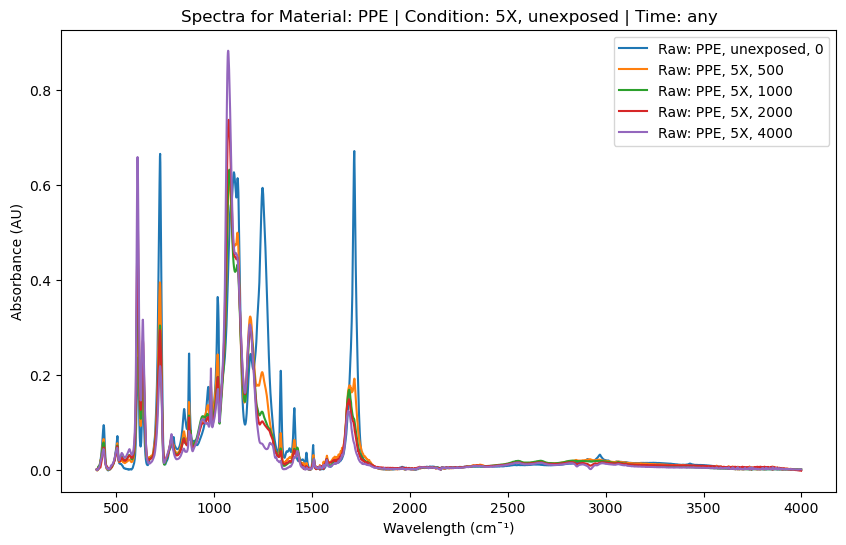

Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\04-25-2024\PPE_unexposed_1.dpt


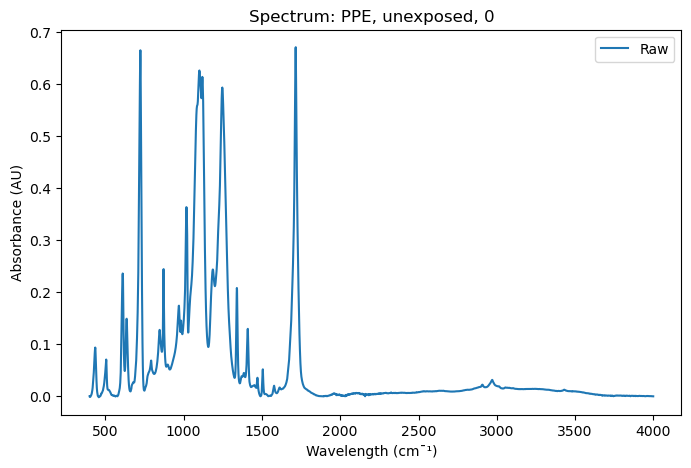

Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\11-06-2024\5X_PPE_500hr.dpt


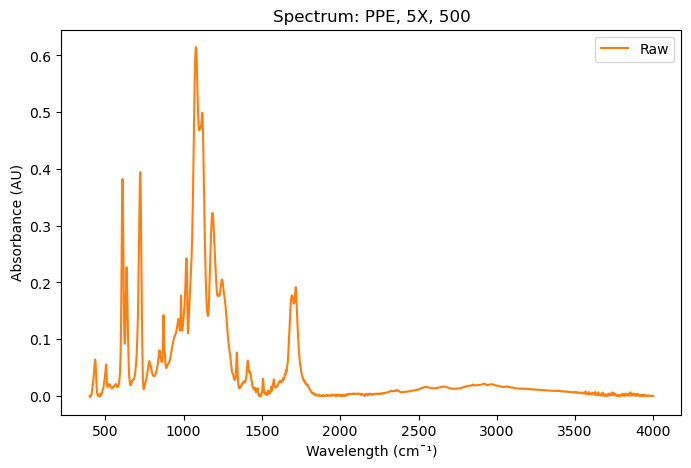

Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\12-18-2024\PPE_5X_1000hr.dpt


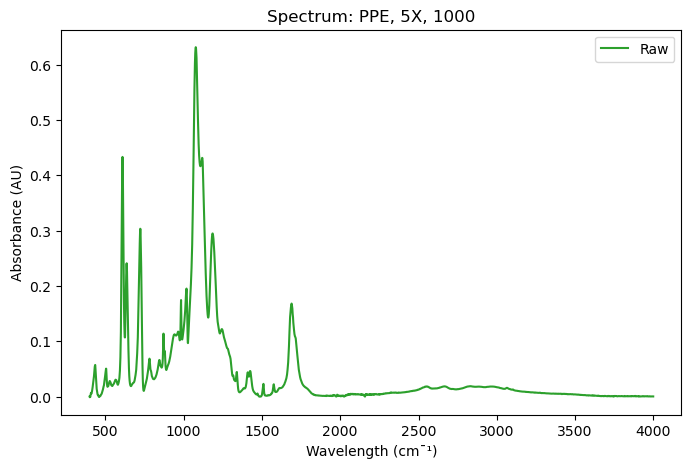

Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\02-05-2025\5X_2000hr_PPE.dpt


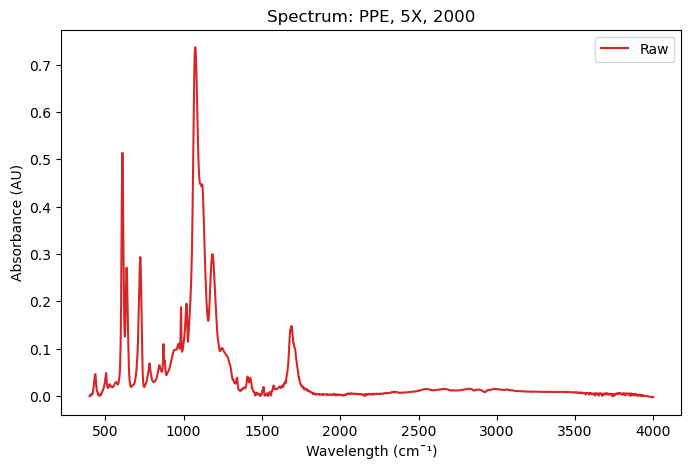

Plotting: Y:\5200\Packaging Reliability\Durability Tool\Ray Tracing and Activation Spectrum\ATR-FTIR Data\05-16-2025\5X_PPE_4000hr.dpt


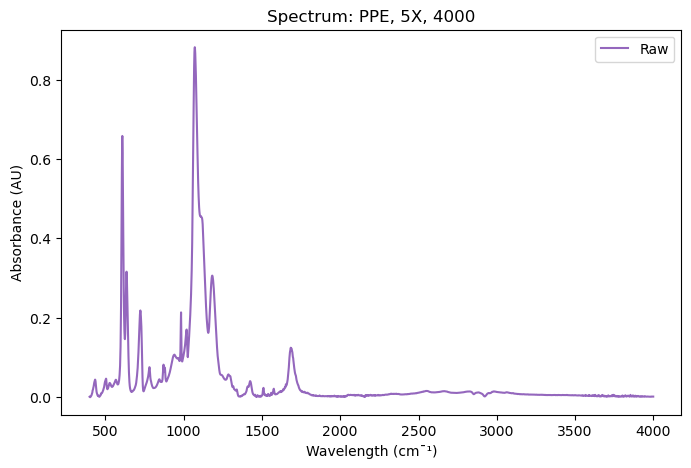

In [5]:
# Set parameters for filtering and plotting
materials = "PPE"  # Example material
conditions = "5X, unexposed"  # Example conditions
times = "any"       # Example time
raw_data = True
baseline = False
baseline_corrected = False
separate_plots = True
include_replicates = False
zoom = None # Set to "x_minimum-x_maximum" format, e.g., "400-4000", or None for no zoom

# Call the function to plot the grouped spectra
%matplotlib inline
plot_grouped_spectra(FTIR_dataframe=FTIR_dataframe, materials=materials, conditions=conditions, times=times, raw_data=raw_data, baseline=baseline, baseline_corrected=baseline_corrected, separate_plots=separate_plots, include_replicates=include_replicates, zoom=zoom)

## Baseline Correction Options
You can choose the baseline correction function and its parameters for your dataframe. This step allows you to fine-tune how baseline correction is applied to your FTIR data.

Baseline Options:

'GIFTS': straight line fit to the data and iteratively discards points that do not fit the line well. This is an asymmetric least squares (ALS) method. [Pros: fast] [Cons: unreliable accuracy]

'IRSQR': iterative reweighted spline quantile regression-- uses penalized splines and iterative reweighted least squares to perform quantile regression. [Pros: decent accuracy] [Cons: middling speed]

'FABC': fully automatic baseline correction-- uses first derivative approximation of data to identify and then ignore peak regions, then fits to baseline regions using Whittaker smoothing. [Pros: can handle noise well, decent accuracy] [Cons: middling speed]

'Manual': set "anchor points" for each of your materials using the built-in tool. This will create a list of wavenumber values that should be in baseline regions for every scan of that material. A cubic spline interpolation will be done between those points' values in each scan. [Pros: customizable, accurate] [Cons: requires manual entry for each material type]

### Try Baselines Out
Try out different baseline types and parameter options without saving the results. The function will find the first file of your selected material with time == 0 (aka non-degraded) and display what the currently chosen settings will create for a baseline.

For custom parameters, structure like so: parameter_string="lam=100, quantile=0.05"

Accepts a filepath as an argument if you want to experiment with a specific file. In that case, "material" argument will be ignored.

#### For non-manual baselines:

In [ ]:
filepath = None # If None, will find first Time-Zero file of the specified material
material = None
baseline_function = None
parameter_string = None # For custom parameters, structure like so: parameter_string="lam=100, quantile=0.05". Default parameters will be used if None.

try_baseline(FTIR_dataframe, material=material, baseline_function=baseline_function, parameter_string=parameter_string, filepath=filepath)

#### For manual baseline:

In [ ]:
filepath = None # If None, will find first Time-Zero file of the specified material
material = "PPE"
select_anchor_points(FTIR_dataframe, material=material, filepath=filepath, try_it_out=True)

### Baseline Selection
materials_to_use should be a list, e.g. "PPE, Perovskite, Plexiglass", quotation marks included.

In [ ]:
### GIFTS ###
materials_to_use = None
if materials_to_use:
    baseline_selection(dataframe_path=dataframe_path, materials_to_use=materials_to_use, baseline_function='GIFTS')

### IRSQR ###
materials_to_use = None
if materials_to_use:
    baseline_selection(dataframe_path=dataframe_path, materials_to_use=materials_to_use, baseline_function='IRSQR')

### FABC ###
materials_to_use = None
if materials_to_use:
    baseline_selection(dataframe_path=dataframe_path, materials_to_use=materials_to_use, baseline_function='FABC')

### Manual Selection ###
materials_to_use = None
if materials_to_use:
    baseline_selection(dataframe_path=dataframe_path, materials_to_use=materials_to_use, baseline_function='MANUAL')

### Parameter Selection

#### GIFTS Parameters
lam (float): Smoothness parameter (higher = smoother baseline).

p (float): Asymmetry parameter (0 < p < 1).

iterations (integer): Number of iterations.

#### IRSQR Parameters
lam (float): The smoothing parameter (higher = smoother baseline).

quantile (float): The quantile at which to fit the baseline (0 < quantile < 1).

num_knots (integer): The number of knots for the spline.

spline_degree (integer): The degree of the spline.

diff_order (integer): The order of the differential matrix. Must be greate matrix). Typical values are 3, 2, or 1.

max_iter (integer): The max number of fit iterations.

tol (float): The exit criteria.

weights (array-like): The weighting array. If None (default), then the initial weights will be an array with size equal to N and all values set to 1.

eps (float): A small value added to the square of the residual to prevent dividing by 0. Default is None, which uses the square of the maximum-absolute-value of the fit each iteration multiplied by 1e-6.

#### FABC Parameters
lam (float): The smoothing parameter (higher = smoother baseline).

scale (integer): The scale at which to calculate the continuous wavelet transform. Should be approximately equal to the index-based full-width-at-half-maximum of the peaks or features in the data. Default is None, which will use half of the value from :func:`.optimize_window`, which is not always a good value, but at least scales with the number of data points and gives a starting point for tuning the parameter.

num_std (float): The number of standard deviations to include when thresholding. Higher values
will assign more points as baseline.

diff_order (integer): The order of the differential matrix. Must be greater than 0. Typical values are 2 or 1.

min_length (integer): Any region of consecutive baseline points less than `min_length` is considered to be a false positive and all points in the region are converted to peak points. A higher `min_length` ensures less points are falsely assigned as baseline points. Default is 2, which only removes lone baseline points.

weights (array-like): The weighting array, used to override the function's baseline identification to designate peak points. Only elements with 0 or False values will have an effect; all non-zero values are considered baseline points. If None, then will be an array with size equal to N and all values set to 1.

weights_as_mask (bool): If True, signifies that the input `weights` is the mask to use for fitting, which skips the continuous wavelet calculation and just smooths the input data.

pad_kwargs (dict): A dictionary of keyword arguments to pass to :func:`.pad_edges` for padding the edges of the data to prevent edge effects from convolution for the continuous wavelet transform. Default is None.

### Manual Parameters
anchor_points (float): The manually selected anchor points, from which the baseline is constructed via a cubic spline interpolation between them. The points are selected in one file from the regions that should always remain outside of peaks for that material, under reasonable degradation conditions. The points associated with these wavenumbers will be accessed in each file and a separate interpolation will be done for each one. So while the anchor points are the same in every spectrum, the actual baseline correction will be personalized for each.

### Test Baselines
Generates plots with the selected baseline and parameters for five random files of the specified material. Allows for quality check.

### Save the Dataframe

In [ ]:
# Save the DataFrame to CSV
dataframe_path = dataframe_path # Specify the path to your DataFrame CSV file (default will be FTIR_dataframe.csv in active directory)
FTIR_dataframe.to_csv(dataframe_path, index=False)